In [2]:
import numpy as np
import sklearn
import random
import math
from sklearn import datasets
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn import svm
%matplotlib inline

Get Data again

In [4]:
digits = datasets.load_digits()

<h1> Aufgabe 3.2 a) </h1>
Erzeugen Sie zunächst 3 Sätze und trainieren Sie für jeden Satz eine SVM mit gamma = 0.001 und C = 1 und geben Sie jeweils die Treffergenauigkeit für Trainings- und Testdatensatz aus. Die Ergebnisse sollten ähnlich wie in Aufgabe 1b aussehen.

In [5]:
for i in range(0, 3):

    train_data, test_data, train_label, test_label = model_selection.train_test_split(digits.data, digits.target, test_size=0.25)
    SVM = svm.SVC(C=100.0, gamma=0.001, kernel="rbf")
    SVM.fit(train_data, train_label)
        
    print(f"""
    Model {i}:\n
    Score on Train:\t{round(SVM.score(train_data, train_label), 3)}
    Score on Test:\t{round(SVM.score(test_data, test_label), 3)}
    """)


    Model 0:

    Score on Train:	1.0
    Score on Test:	0.991
    

    Model 1:

    Score on Train:	1.0
    Score on Test:	0.989
    

    Model 2:

    Score on Train:	1.0
    Score on Test:	0.989
    


<h1> Aufgabe 3.2 b) </h1>
Statt wie in 2a von Hand vorzugehen gibt es in Scikit Learn die bereits vordefinierte Methode sklearn.model_selection.cross_val_score(). Wiederholen Sie Ihr Experiment aus Aufgabe 2a mit 10 Zufallssplits und geben Sie jeweils die Treffergenauigkeit auf dem Testdatensatz aus. Berechnen Sie die mittlere Treffergenauigkeit (die Kreuzvalidierungsgenauigkeit) und die Standardabweichung des Mittelwerts.

In [7]:
SVM = svm.SVC(C=100.0, gamma=0.001, kernel="rbf")
scores = model_selection.cross_val_score(estimator=SVM,
                                        X=train_data,
                                        y=train_label,
                                        cv=10)
print(f"""
Cross Validation Scores:
Kreuzvalidierungsgenauigkeit:\t{round(scores.mean(), 3)}
Standardabweichung:\t\t{round(math.sqrt(scores.var()), 3)}
""")


Cross Validation Scores:
Kreuzvalidierungsgenauigkeit:	0.99
Standardabweichung:		0.009



<h1> Aufgabe 3.2 c) </h1>

In [8]:
gammas = np.logspace(-7, -1, 10)
gammas = np.around(gammas, 7)
results_train = []
results_test = []
for split in range(0, 5):

    train_data, test_data, train_label, test_label = model_selection.train_test_split(digits.data, digits.target, train_size=500, test_size=500)
    results_train.append([])
    results_test.append([])

    for gamma in gammas:

        SVM = svm.SVC(C=10.0, gamma=gamma, kernel="rbf")
        SVM.fit(train_data, train_label)

        results_train[-1].append(SVM.score(train_data, train_label))
        results_test[-1].append(SVM.score(test_data, test_label))

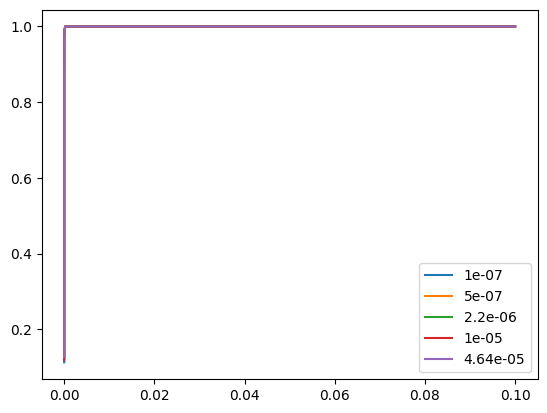

In [9]:
# Plot the results for train
for index, split in enumerate(results_train):
    plt.plot(gammas, split)
plt.legend(gammas)
plt.show()


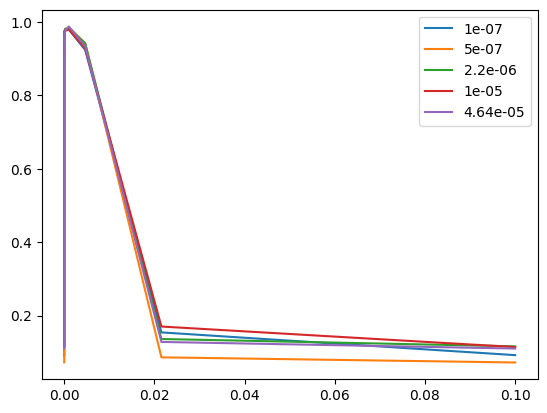

In [10]:
# Plot the results for test
for index, split in enumerate(results_test):
    plt.plot(gammas, split)
plt.legend(gammas)
plt.show()


<h1> Aufgabe 3.2 d) </h1>

In [13]:
svc_params = {
'C': np.logspace(-1, 2, 4),
'gamma': np.logspace(-4, 0, 5), 
}

train_data, test_data, train_label, test_label = model_selection.train_test_split(digits.data, digits.target, train_size=500)

SVM = svm.SVC(C=10.0, gamma=0.1, kernel="rbf")
model = model_selection.GridSearchCV(param_grid=svc_params, cv=3, estimator=SVM).fit(train_data, train_label)

print(f"""
Best Params:\t\t{model.best_params_}
Best Score:\t\t{model.best_score_}
Score on Test data:\t{model.score(test_data, test_label)}
""")

#print(f"\n{model.cv_results_}")



Best Params:		{'C': 10.0, 'gamma': 0.001}
Best Score:		0.983983839549816
Score on Test data:	0.9791827293754819

